In [29]:
import numpy as np
import scipy.io as sio
import matplotlib.lines as lines
import matplotlib.pyplot as plt
import cvxpy as cp
#import core

In [30]:
%run gp.py
%run kernel_gp.py
%run rf_gp.py

In [31]:
def interface(x_train, y_train, z_train):
    ker_obj = KernelGP(x_train, y_train, z_train)
    rf_obj = RandomFeaturesGP(x_train, y_train, z_train)
    ker_obj.train()
    ker_obj.c_train()
    rf_obj.train()
    rf_obj.c_train()
    return ker_obj, rf_obj

In [32]:
#inverted pendulum

data = sio.loadmat('invpendulum_data.mat')
x_train = data['x_gp']
u_train = data['u_gp']
z_train = data['z_gp']
y_train= np.concatenate((np.ones((len(u_train),1)), u_train), axis=1)
z_train = z_train.flatten()
k_pen, rf_pen = interface(x_train, y_train, z_train)
kpred_pen = k_pen.test(x_train[0])
rfpred_pen = rf_pen.test(x_train[0])

print(f'kernel training time{k_pen.training_time}, rf training time{rf_pen.training_time}')
print(f'kernel test time{k_pen.test_time}, rf test time{rf_pen.test_time}')

kernel training time0.0032807259999572125, rf training time0.0384153760001027
kernel test time0.00014978099989093607, rf test time0.0004729490001409431


In [33]:
beta = 1
ld = 1
#define and solve SOCP
u = cp.Variable(rf_pen.m+1)
soc_contraints = [ rf_pen.c_test(u) + beta * rf_pen.sigma**2 \
                  * np.einsum('ij,jk,ki->i', rf_pen._compute_cphi(rf_pen.phi_test, u), \
                    rf_pen.inv_cphi, rf_pen._compute_cphi(rf_pen.phi_test, u).T) \
                 + ld <= 0]
prob = cp.Problem(cp.Minimize(la.norm(y_test)), soc_constraints)
prob.solve()

#print results
print("The optimal value is", prob.value)
print("A solution x is")
print(x.value)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [5]:
dif_k = np.abs(k_pen.kernel-rf_pen.estimate_kernel())
dif_ck = np.abs(k_pen.c_kernel-rf_pen.estimate_ckernel())
mean_dif_k = np.mean(dif_k <.01)
mean_dif_ck = np.mean(dif_ck < .01)
print(f'Mean diff kernel: {mean_dif_k}, Mean diff compound kernel {mean_dif_ck}')


#print(f'difference in kernel estimate:{dif_k}')
print('rf_error',la.norm(k_pen.test(x_train)- z_train),\
      'kernel error',la.norm(rf_pen.test(x_train)-z_train))

Mean diff kernel: 0.5351814396192742, Mean diff compound kernel 0.48616299821534803
rf_error 6.4925653666589564 kernel error 6.364137442280501


In [6]:
# plt.plot(x_train[:,0], z_train, 'g.', label = 'actual data')
# plt.plot(x_train[:,0], kpred_pen, 'b.', label = 'kernel pred')
# plt.plot(x_train[:,0], rfpred_pen, 'r.', label = 'rf pred')
# plt.xlabel('state x[0]')
# plt.ylabel('predicton')
# plt.title('prediction errorprojected on x[0]')
# plt.legend()
# plt.draw()
# plt.figure()

# plt.plot(x_train[:,1], z_train, 'g.', label = 'actual data')
# plt.plot(x_train[:,1], kpred_pen, 'b.', label = 'kernel pred')
# plt.plot(x_train[:,1], rfpred_pen, 'r.', label = 'rf pred')
# plt.xlabel('state x[1]')
# plt.ylabel('predicton')
# plt.title('prediction error projected on x[1]')
# plt.legend()
# plt.draw()
# plt.figure()

# plt.plot(y_train[:,1], z_train, 'g.', label = 'actual data')
# plt.plot(y_train[:,1], kpred_pen, 'b.', label = 'kernel pred')
# plt.plot(y_train[:,1], rfpred_pen, 'r.', label = 'rf pred')
# plt.xlabel('control input')
# plt.ylabel('predicton')
# plt.title('prediction error projected on y')
# plt.legend()
# plt.draw()
# plt.figure()

In [10]:
#ACC

data = sio.loadmat('acc_all.mat')

xs = data['allx'].T
ys = data['ally'].T
zs = data['allz']
zs = zs[1,:] # IMPORTANT (use either z_train[1,:] or [0,:] for CBF/CLF training)
zs = zs.flatten()

k_acc = KernelGP(xs, ys, zs)
rf_acc = RandomFeaturesGP(xs, ys, zs)
k_acc.train()
k_acc.c_train()
rf_acc.train()
rf_acc.c_train()
kpred_acc = k_acc.test(xs)
kcpred_acc = k_acc.c_test(ys)
rfpred_acc = rf_acc.test(xs)
rfcpred_acc = rf_acc.c_test(ys)
kcsigma_acc = k_acc.c_sigma(ys)
rfcsigma_acc = rf_acc.c_sigma()

szs=zs[1121:]
srfcpred_acc=rfcpred_acc[1121:]
skcpred_acc=kcpred_acc[1121:]
srfcsigma_acc=rfcsigma_acc[1121:]
skcsigma_acc=kcsigma_acc[1121:]

print(f'kernel training time{k_acc.training_time}, rf training time{rf_acc.training_time}')
print(f'kernel test time{k_acc.test_time}, rf test time{rf_acc.test_time}')
k_error = np.sqrt(np.sum(np.square(kpred_acc - zs)))
rf_error = np.sqrt(np.sum(np.square(rfpred_acc - zs)))
kc_error = np.sqrt(np.sum(np.square(kcpred_acc - zs)))
rfc_error = np.sqrt(np.sum(np.square(rfcpred_acc - zs)))
print(f'kernel error{k_error},rf error{rf_error}')
print(f'ckernel error{kc_error},rfc error{rfc_error}')
print(f'ckernel sigma: {np.sum(np.abs(kcsigma_acc))}, \
            rfc sigma: {np.sum(np.abs(rfcsigma_acc))}')

# x_train = data['allx'].T
# y_train = data['ally'].T
# z_train = data['allz']

#for smaller data size
# data = sio.loadmat('acc_data.mat')
# x_train = data['xs_train'].T
# y_train = data['ys_train'].T
# z_train = data['zs_train']


# c= 1
# plt.plot(xs[:,0],zs, 'g.', label = 'actual data', markersize =c )
# plt.plot(xs[:,0], kpred_acc, 'b.', label = 'kernel pred',markersize =c )
# plt.plot(xs[:,0],rfpred_acc, 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('x0')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("label-x0")
# plt.figure()


# plt.plot(xs[:,1],zs, 'g.', label = 'actual data', markersize =c )
# plt.plot(xs[:,1], kpred_acc, 'b.', label = 'kernel pred',markersize =c )
# plt.plot(xs[:,1],rfpred_acc, 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('x1')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("label-x1")
# plt.figure()

# plt.plot(xs[:,2],zs, 'g.', label = 'actual data', markersize =c )
# plt.plot(xs[:,2], kpred_acc, 'b.', label = 'kernel pred',markersize =c )
# plt.plot(xs[:,2],rfpred_acc, 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('x2')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("label-x2")
# plt.figure()

# plt.plot(ys[:,1],zs, 'g.', label = 'actual data', markersize =c )
# plt.plot(ys[:,1], kpred_acc, 'b.', label = 'kernel pred',markersize =c )
# plt.plot(ys[:,1],rfpred_acc, 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('ys')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("label-y")
# plt.figure()


kernel training time0.41616131299997505, rf training time0.0756602080000448
kernel test time0.08983817000000727, rf test time0.0686791450000328
kernel error18.764847450400936,rf error27.174189267224204
ckernel error1.5661601645394337e-05,rfc error0.0002001508715442764
ckernel sigma: 488.9057468822848,             rfc sigma: 275.8808824232571


<Figure size 432x288 with 0 Axes>

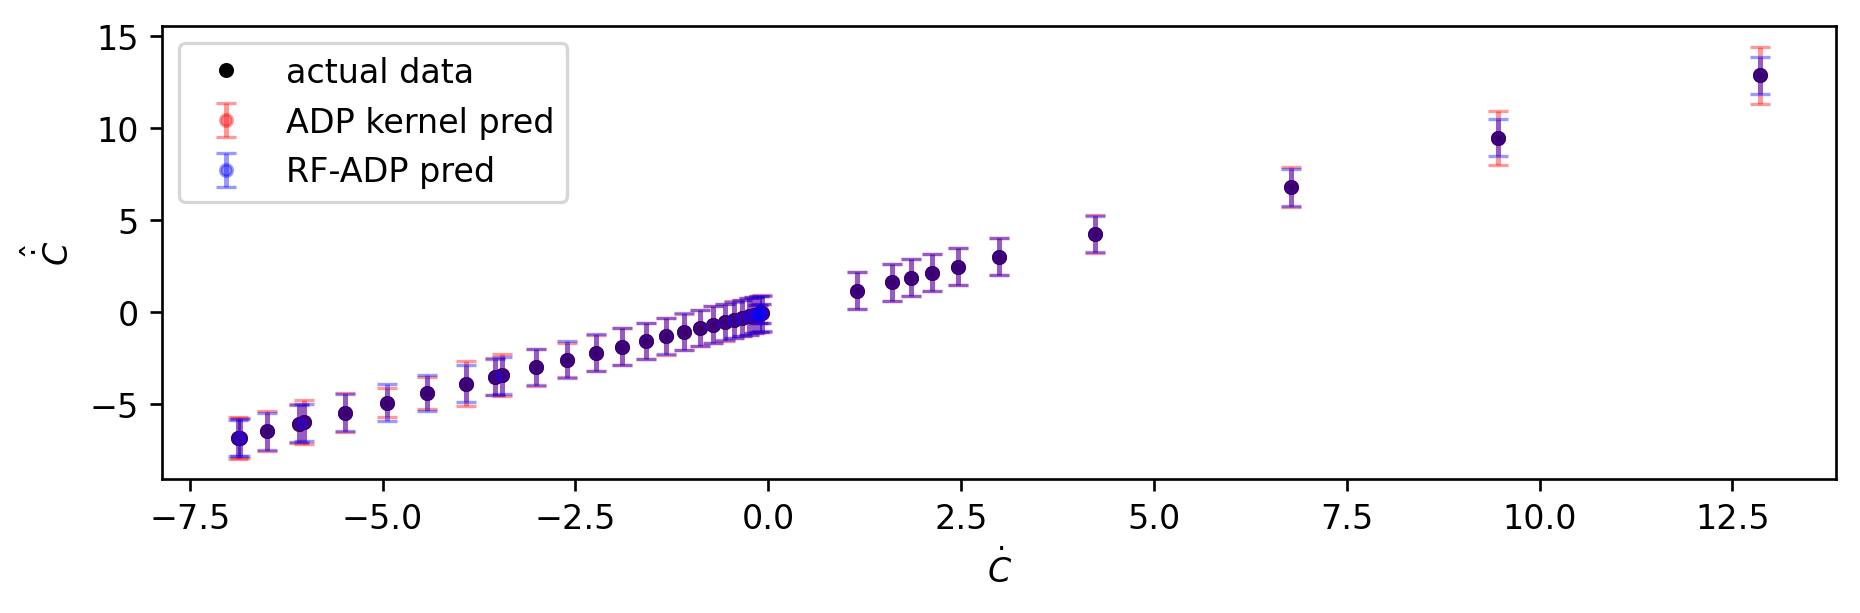

<Figure size 432x288 with 0 Axes>

In [11]:
time = np.arange(0,116,1)
c=7
# plt.plot(time,zs[1044:], 'g.', label = 'actual data', markersize =c )
# plt.plot(time, kpred_acc[1044:], 'b.', label = 'kernel pred',markersize =c )
# plt.plot(time,rfpred_acc[1044:], 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('time')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("t")
# plt.figure()

plt.figure(figsize=(9, 2.5), dpi=240)
plt.errorbar(szs, skcpred_acc, skcsigma_acc, fmt='r.', label = 'ADP kernel pred', alpha= .4, markersize =c, capsize =3)
plt.errorbar(szs, srfcpred_acc, srfcsigma_acc, fmt='b.', label = 'RF-ADP pred' , alpha=.4, markersize =c, capsize =3)
plt.plot(szs,szs, 'k.' , label = 'actual data', markersize =c)
plt.xlabel('$\dot{C}$')
plt.ylabel('$\hat{\dot{C}}$')
plt.legend()
plt.draw()
plt.savefig("pred-label",bbox_inches = "tight")
plt.figure()


kernel training time0.22522972100159677, rf training time0.036801885999011574
kernel test time0.006422338999982458, rf test time0.006846053000117536
kernel error12.817773078861206,rf error12.616726063198875
ckernel error1.0478198642415084,rfc error1.2370944188625728
kernel sigma: 67512562.63369837,             rf sigma: 10625575.566196857


<Figure size 432x288 with 0 Axes>

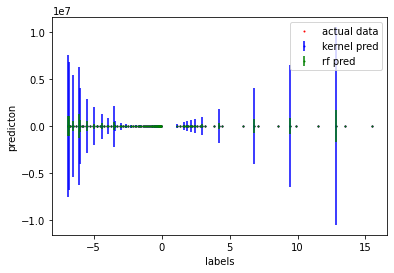

<Figure size 432x288 with 0 Axes>

In [127]:
x_train = xs[:1044]
y_train = ys[:1044]
z_train = zs[:1044] # IMPORTANT (use either z_train[1,:] or [0,:] for CBF/CLF training)
z_train = z_train.flatten()
x_valid = xs[1044:]
y_valid = ys[1044:]
z_valid = zs[1044:]


k_acc, rf_acc = interface(x_train, y_train, z_train)
kpred_acc = k_acc.test(x_valid)
kcpred_acc = k_acc.c_test(y_valid)
rfpred_acc = rf_acc.test(x_valid)
rfcpred_acc = rf_acc.c_test(y_valid)
kcsigma_acc = k_acc.c_sigma(y_valid)
rfcsigma_acc = rf_acc.c_sigma()
print(f'kernel training time{k_acc.training_time}, rf training time{rf_acc.training_time}')
print(f'kernel test time{k_acc.test_time}, rf test time{rf_acc.test_time}')
k_error = np.sqrt(np.sum(np.square(kpred_acc - z_valid)))
rf_error = np.sqrt(np.sum(np.square(rfpred_acc - z_valid)))
kc_error = np.sqrt(np.sum(np.square(kcpred_acc - z_valid)))
rfc_error = np.sqrt(np.sum(np.square(rfcpred_acc - z_valid)))
print(f'kernel error{k_error},rf error{rf_error}')
print(f'ckernel error{kc_error},rfc error{rfc_error}')
print(f'kernel sigma: {np.sum(np.abs(kcsigma_acc))}, \
            rf sigma: {np.sum(np.abs(rfcsigma_acc))}')
# rf_d= np.arange(100,1000,50)
# for x in rf_d:
#     self.rf_d = x

# plt.plot(z_valid,z_valid, 'r.' , label = 'actual data', markersize =c)
# plt.errorbar(z_valid, kpred_acc, kcsigma_acc, fmt='b.', label = 'kernel pred', markersize =c )
# plt.errorbar(z_valid, rfpred_acc, rfcsigma_acc, fmt='g.', label = 'rf pred' , markersize =c)
# plt.xlabel('labels')
# plt.ylabel('predicton')
# plt.legend()
# plt.draw()
# plt.savefig("pred-label")
# plt.figure()

KeyboardInterrupt: 

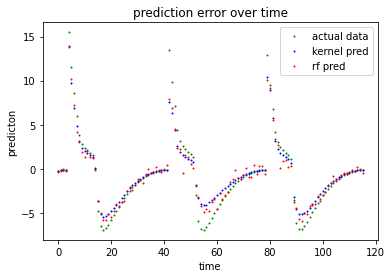

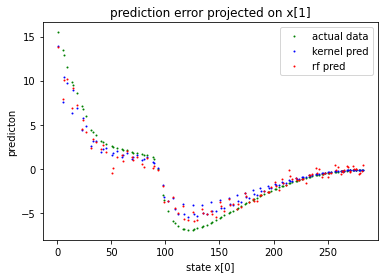

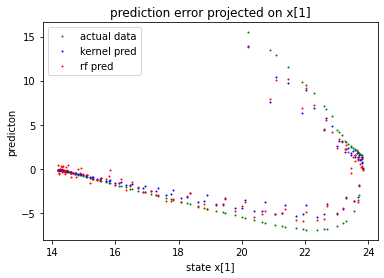

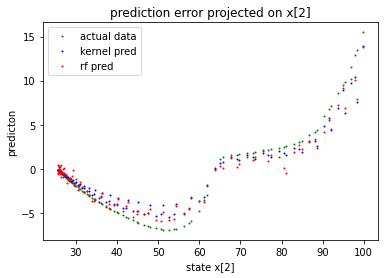

In [128]:
# time = np.arange(0,116,1)
# c=2
# plt.plot(time,z_valid, 'g.', label = 'actual data', markersize =c )
# plt.plot(time, kpred_acc, 'b.', label = 'kernel pred',markersize =c )
# plt.plot(time,rfpred_acc, 'r.', label = 'rf pred',markersize =c )
# plt.xlabel('time')
# plt.ylabel('predicton')
# plt.title('prediction error over time')
# plt.legend()
# plt.draw()
# plt.savefig("t")
# plt.figure()

# plt.plot(x_valid[:,0],z_valid, 'g.', label = 'actual data', markersize =c)
# plt.plot(x_valid[:,0], kpred_acc, 'b.', label = 'kernel pred', markersize =c)
# plt.plot(x_valid[:,0],rfpred_acc, 'r.', label = 'rf pred', markersize =c)
# plt.xlabel('state x[0]')
# plt.ylabel('predicton')
# plt.title('prediction error projected on x[1]')
# plt.legend()
# plt.draw()
# plt.savefig("x0")
# plt.figure()

# plt.plot(x_valid[:,1],z_valid, 'g.', label = 'actual data', markersize =c)
# plt.plot(x_valid[:,1], kpred_acc, 'b.', label = 'kernel pred', markersize =c)
# plt.plot(x_valid[:,1],rfpred_acc, 'r.', label = 'rf pred', markersize =c)
# plt.xlabel('state x[1]')
# plt.ylabel('predicton')
# plt.title('prediction error projected on x[1]')
# plt.legend()
# plt.draw()
# plt.savefig("x1")
# plt.figure()

# plt.plot(x_valid[:,2],z_valid, 'g.', label = 'actual data', markersize =c)
# plt.plot(x_valid[:,2], kpred_acc, 'b.', label = 'kernel pred', markersize =c)
# plt.plot(x_valid[:,2],rfpred_acc, 'r.', label = 'rf pred', markersize =c)
# plt.xlabel('state x[2]')
# plt.ylabel('predicton')
# plt.title('prediction error projected on x[2]')
# plt.legend()
# plt.draw()
# plt.savefig("x2")
# plt.figure()

# plt.plot(y_valid[:,1],z_valid, 'g.', label = 'actual data', markersize =c)
# plt.plot(y_valid[:,1], kpred_acc, 'b.', label = 'kernel pred', markersize =c)
# plt.plot(y_valid[:,1],rfpred_acc, 'r.', label = 'rf pred', markersize =c)
# plt.xlabel('control input')
# plt.ylabel('predicton')
# plt.title('prediction error projected on y')
# plt.legend()
# plt.draw()
# plt.savefig("y")
# plt.figure()

In [ ]:
# z_train = data['allz']
# z_train = z_train[0,:] # IMPORTANT (use either z_train[1,:] or [0,:] for CBF/CLF training)
# z_train = z_train.flatten()
# k2_acc = KernelGP(x_train, y_train, z_train)
# rf2_acc = RandomFeaturesGP(x_train, y_train, z_train)
# k2_acc.train()
# k2_acc.c_train()
# rf2_acc.train()
# rf2_acc.c_train()
# kpred2_acc = k2_acc.test(x_train)
# kcpred2_acc = k2_acc.c_test(y_train)
# rfpred2_acc = rf2_acc.test(x_train)
# rfcpred2_acc = rf2_acc.c_test(y_train)

# print(f'kernel training time{k_acc.training_time}, rf training time{rf_acc.training_time}')
# print(f'kernel test time{k_acc.test_time}, rf test time{rf_acc.test_time}')
# kc_error = np.sqrt(np.sum(np.square(kcpred_acc - z_train)))
# rf_error = np.sqrt(np.sum(np.square(rfpred_acc - z_train)))
# rfc_error = np.sqrt(np.sum(np.square(rfcpred_acc - z_train)))
# print(f'ckernel error{k_error},rfc error{rfc_error}')
# print(f'kernel sigma: {np.sum(np.abs(k_acc.c_sigma(y_train)))}, \
#             rf sigma: {np.sum(np.abs(rf_acc.c_sigma()))}')

# plt.plot(time,z_train, 'g.', label = 'actual data', markersize =1 )
# plt.plot(time, kpred_acc, 'b.', label = 'kernel pred',markersize =1 )
# plt.plot(time,rfpred_acc, 'r.', label = 'rf pred',markersize =1 )
# plt.xlabel('state x[0]')
# plt.ylabel('predicton')
# plt.title('prediction errorprojected on x[0]')
# plt.legend()
# plt.draw()
# plt.savefig("x0")
# plt.figure()